<a href="https://colab.research.google.com/github/gamma-opt/icnn/blob/main/example_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount git hub repo
!git clone https://github.com/gamma-opt/icnn.git


Cloning into 'icnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 117.99 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
# install julia
%%shell
set -e
wget -nv https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh -O /tmp/install_colab.sh
bash /tmp/install_colab.sh  # Takes ~ 2 minutes

2024-11-21 14:52:17 URL:https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh [1058/1058] -> "/tmp/install_colab.sh" [1]
Installing Julia 1.10.5 on the current Colab Runtime...
2024-11-21 14:52:19 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.5-linux-x86_64.tar.gz [173909866/173909866] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


Now,
- go to the "Runtime" tab
- select "Change runtime type"
- select julia in the "Runtime type" dropdown
- click "save"

You might need to refresh the page.


In [ ]:
import Pkg
Pkg.add("Gogeta")
Pkg.add("JuMP")
Pkg.add("Plots")
Pkg.add("JSON")
Pkg.add("Alpine")
Pkg.add("HiGHS")
Pkg.add("Juniper")
Pkg.add("Ipopt")

In [1]:
using Gogeta
using JuMP
using Plots
using JSON
using Alpine
using HiGHS
using Juniper
using Ipopt

# replace with the path to the model_weights.json file
filepath = "model_weights_2D.json"

# Read the JSON file
json_content = read(filepath, String)

# Parse the JSON content
parsed_json = JSON.parse(json_content)

Dict{String, Any} with 3 entries:
  "FC2"   => Any[Any[Any[0.667317], Any[1.52441]], Any[-2.1556]]
  "SKIP2" => Any[Any[Any[-2.07353]]]
  "FC1"   => Any[Any[Any[-2.05871, 1.12061]], Any[-0.948954, 2.04866]]

In [60]:
#-----------------------------ICNN-------------------------------------------------#

# Configure Ipopt to be silent
nlp_solver = optimizer_with_attributes(
    Ipopt.Optimizer,
    "print_level" => 0
)

# Configure Juniper to be silent
juniper_solver = optimizer_with_attributes(
    Juniper.Optimizer,
    "nl_solver" => nlp_solver,
    "log_levels" => []
)

# Configure HiGHS to be silent
milp_solver = optimizer_with_attributes(
    HiGHS.Optimizer,
    "output_flag" => false
)

# Create the Alpine optimizer with silent logging
alpine_optimizer = optimizer_with_attributes(
    Alpine.Optimizer,
    "nlp_solver" => juniper_solver,
    "mip_solver" => milp_solver,
    "log_level" => 0  # Ensure Alpine's logging is silent
)

# define the icnn model
icnn_lp =  Model(alpine_optimizer)

# define the output variable
icnn_output_var = @variable(icnn_lp, z, base_name="output_var")

# define the input variable
icnn_input_var = @variable(icnn_lp, x, base_name="input_var")

# define the objective function
@objective(icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(icnn_lp, x <= 3)
@constraint(icnn_lp, x >= -3)

# add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(icnn_lp, filepath, icnn_output_var, icnn_input_var)

output_var

In [3]:
function forwardpass(jump_model, input_values)
    
    fix(jump_model[:x], input_values; force = true)
    optimize!(jump_model)

    # Get the values BEFORE unfixing
    result = value.(jump_model[:z])
    # Unfix the variables for future use
    unfix.(jump_model[:x])

    return result
end

forwardpass (generic function with 1 method)

In [4]:
print(icnn_lp)

Min output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= 3


In [5]:
#---------------------------Out ICNN-----------------------------------------------#
# define the outter jump model
out_icnn_lp = Model(alpine_optimizer)

# define the output variable
out_output_var = @variable(out_icnn_lp, z, base_name="output_var")

# define the input variable
out_input_var = @variable( out_icnn_lp, x, base_name="input_var")

# define the objective
@objective(out_icnn_lp, Min, 0)

# define the constraints on input variable
@constraint(out_icnn_lp, x <= 3)
@constraint(out_icnn_lp, x >= -3)


input_var >= -3

In [6]:
print(out_icnn_lp)

Min 0
Subject to
 input_var >= -3
 input_var <= 3


# Example 1: z >= 2 (feasibility)

In [28]:
#---------------------------Example 1----------------------------------------------#

# add contraint on the output variable
@constraint(out_icnn_lp, exm_1, z >= 2)

# define the objective
@objective(out_icnn_lp, Max, x)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x_optimal = value.(out_icnn_lp[:x])
out_z_optimal = value.(out_icnn_lp[:z])

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


-0.1284143

In [29]:
println(out_icnn_lp)

Max input_var - output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 input_var >= -3
 exm_1 : output_var >= 2
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= 3




*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

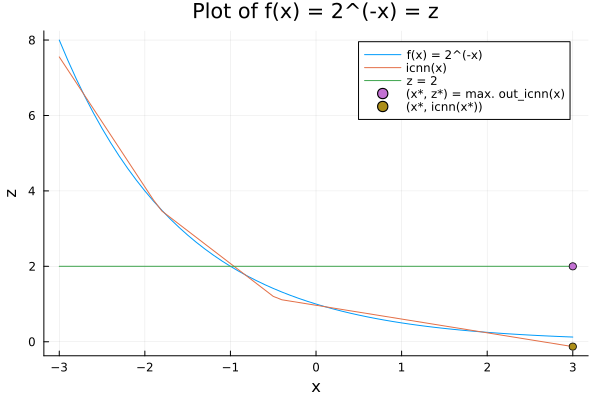

In [30]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

plot!(x_values, 2*ones(length(x_values)), label="z = 2")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

# Example 2: obj x+z (penalty domination)

In [ ]:
#---------------------------Example 2---------------------------------------------#

delete(out_icnn_lp, exm_1)

# define the objective
@objective(out_icnn_lp, Max, x+z)

# add variables, constraints, and an objective function to the out_icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(out_icnn_lp, filepath, out_output_var, out_input_var)

# optimize the outter jump model
optimize!(out_icnn_lp)

# save the input and output values
x_optimal = value.(out_icnn_lp[:x])
out_z_optimal = value.(out_icnn_lp[:z])


*** Alpine ended with status OPTIMAL ***


588446.1167668

In [36]:
println(out_icnn_lp)

Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= 3




*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

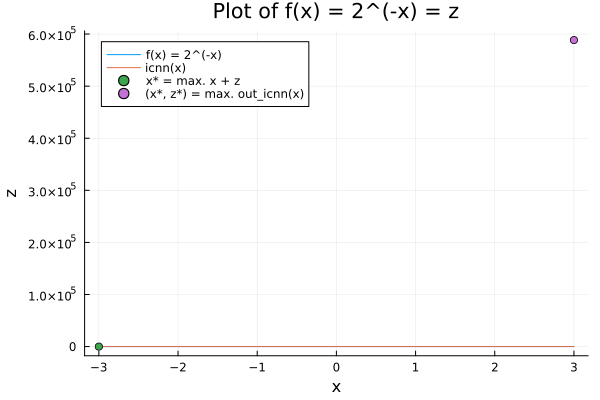

In [37]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

#forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# calculate x+z values
xz = x_values .+ icnn

max_ind = findfirst(x -> x == maximum(xz), xz)
scatter!([x_values[max_ind]], [icnn[max_ind]], label="x* = max. x + z")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")

# Envelope

In [7]:
# define a function that generates a copy of icnn_lp and adds new constraints
function add_envelope_constraints(filepath, extreme_points, obj_sense=:Min, obj_expr=nothing)

    n = length(extreme_points)

    # define the icnn model
    new_icnn_lp =  Model(alpine_optimizer)

    # define the output variable
    new_icnn_output_var = @variable(new_icnn_lp, z, base_name="output_var")

    # define the input variable
    new_icnn_input_var = @variable(new_icnn_lp, x, base_name="input_var")

    # Define objective function
    if obj_expr !== nothing
        # Call the custom objective function with the model variables
        expr = obj_expr(new_icnn_input_var, new_icnn_output_var)
        set_objective(new_icnn_lp, obj_sense, expr)
    end

    # define the constraints on input variable
    @constraint(new_icnn_lp, x <= extreme_points[2])
    @constraint(new_icnn_lp, x >= extreme_points[1])

    # add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
    ICNN_incorporate!(new_icnn_lp, filepath, new_icnn_output_var, new_icnn_input_var)

    # Constraint 1: ai >= 0
    @variable(new_icnn_lp, a[1:n] >= 0)  

    # Constraint 2: x = sum(ai * extreme_points_i)
    @constraint(new_icnn_lp, constraint_2, new_icnn_lp[:x] == sum(a[i] * extreme_points[i] for i in 1:n))

    # Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
    @constraint(new_icnn_lp, constraint_3, new_icnn_lp[:z] <= sum(a[i] * forwardpass(new_icnn_lp, extreme_points[i]) for i in 1:n))

    # Consitrait 4: sum(ai) = 1
    @constraint(new_icnn_lp, constraint_4, sum(a[i] for i in 1:n) == 1)

    return new_icnn_lp

end


add_envelope_constraints (generic function with 3 methods)

In [69]:
function optimise_and_print_results(model_list, icnn_lp)

    results = []

    for i in 1:length(model_list)
        model = model_list[i]
        println("\n----- Optimising Model $i -----")

        optimize!(model)
        
        println("Status: ", termination_status(model))
        
        if termination_status(model) == MOI.OPTIMAL
            obj_optimal = objective_value(model)
            x_optimal = value(model[:x])
            z_optimal = value(model[:z])
            a_values = value.(model[:a])
            icnn_z_optimal = forwardpass(icnn_lp, x_optimal)
            
            # Store all data needed for plotting
            push!(results, (
                model_index = i,
                obj_optimal = obj_optimal,
                x_optimal = x_optimal,
                z_optimal = z_optimal,
                a_values = a_values,
                icnn_z_optimal = icnn_z_optimal
            ))
            
            println("Objective value: ", obj_optimal)
            println("x value: ", x_optimal)
            println("z value: ", z_optimal)
            println("icnn(x) value: ", icnn_z_optimal)
            println("a values:")
            for j in 1:length(a_values)
                println("  a[$j] = ", a_values[j])
            end
        else
            println("Optimisation did not reach optimality.")
        end
    end

    return results
    
end

optimise_and_print_results (generic function with 2 methods)

## z >= 2; min 0

In [10]:
# if you have multiple extreme points
new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MIN_SENSE, (x,z) -> 0)
    # Add the constraint that z >= 2
    @constraint(new_icnn_lp, exm_1, new_icnn_lp[:z] >= 2)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 exm_1 : output_var >= 2
 input_var <= 0
 constraint_3 : output_var - 7.5531774 a[1] - 0.9673938 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

In [11]:
results = optimise_and_print_results(new_icnn_lp_list)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL
Objective value: 1.9999999824948194
x value: -0.6268501
z value: 2.0
a values:
  a[1] = 0.20895
  a[2] = 0.79105

----- Optimising Model 2 -----


┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:263



*** Alpine ended with status INFEASIBLE ***
Status: INFEASIBLE
Optimisation did not reach optimality.


┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:569


1-element Vector{Any}:
 (model_index = 1, x_optimal = -0.6268501, z_optimal = 2.0, a_values = [0.20895, 0.79105])


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

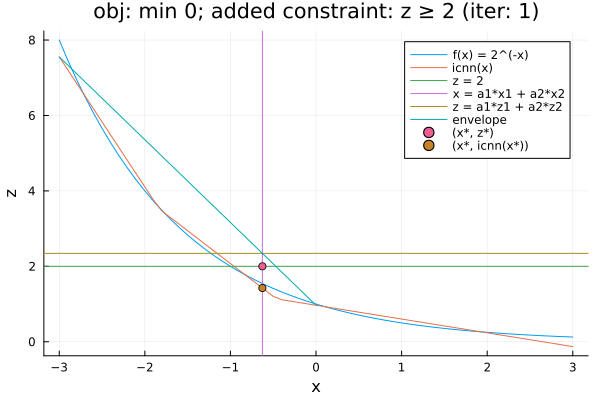

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: min 0; added constraint: z ≥ 2 (itr: 1)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

In [15]:
# define the new branching sets
extreme_points = [[-3, -1.5],[-1.5, 0]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MIN_SENSE, (x,z) -> 0)
    # Add the constraint that z >= 2
    @constraint(new_icnn_lp, exm_1, new_icnn_lp[:z] >= 2)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list)



*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 1.5 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 exm_1 : output_var >= 2
 input_var <= -1.5
 constraint_3 : output_var - 7.5531774 a[1] - 2.9427679 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 1.5 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -1.5
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.048663

2-element Vector{Any}:
 (model_index = 1, x_optimal = -1.5, z_optimal = 2.9427678, a_values = [0.0, 1.0])
 (model_index = 2, x_optimal = -0.8267107, z_optimal = 2.0, a_values = [0.5511405, 0.4488595])


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


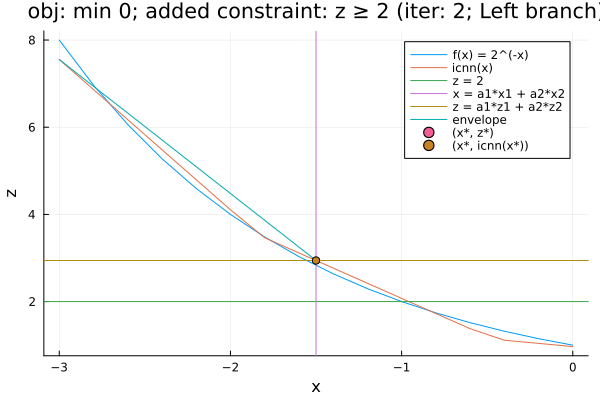

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.2:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: min 0; added constraint: z ≥ 2 (itr: 2; Left branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


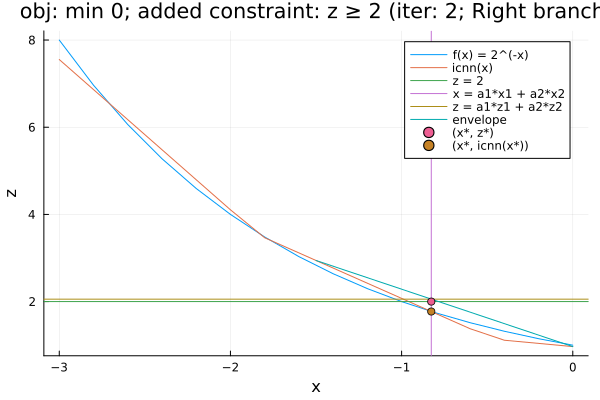

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.2:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[2]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: min 0; added constraint: z ≥ 2 (itr: 2; Right branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[2]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

## z >= 2; max x

In [47]:
# define the branching sets
extreme_points = [[-3, 0],[0,3]]

2-element Vector{Vector{Int64}}:
 [-3, 0]
 [0, 3]

In [48]:
# if you have multiple extreme points
new_icnn_lp_list_max = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x, z) -> x)
    # Add the constraint that z >= 2
    @constraint(new_icnn_lp, exm_1, new_icnn_lp[:z] >= 2)
    new_icnn_lp_list_max[i] = new_icnn_lp
    print(new_icnn_lp)
end



*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var - output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 exm_1 : output_var >= 2
 input_var <= 0
 constraint_3 : output_var - 7.5531774 a[1] - 0.9673938 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var - output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var - 3 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0

In [49]:
results = optimise_and_print_results(new_icnn_lp_list_max, icnn_lp)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -2.4703796236608144
x value: -0.4703796
z value: 2.0
icnn(x) value: 1.1521704
a values:
  a[1] = 0.1567932
  a[2] = 0.8432068

----- Optimising Model 2 -----

*** Alpine ended with status INFEASIBLE ***
Status: INFEASIBLE
Optimisation did not reach optimality.


┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:263
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:569


1-element Vector{Any}:
 (model_index = 1, x_optimal = -0.4703796, z_optimal = 2.0, a_values = [0.1567932, 0.8432068], icnn_z_optimal = 1.1521704)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

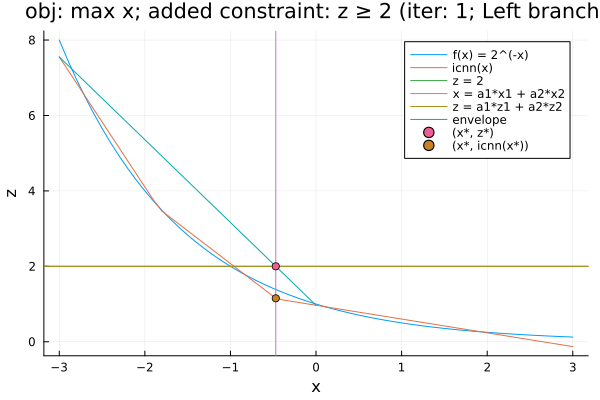

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x; added constraint: z ≥ 2 (itr: 1; Left branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

In [52]:
# define the new branching sets
extreme_points = [[-3, -1.5],[-1.5, 0]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MIN_SENSE, (x,z) -> x)
    # Add the constraint that z >= 2
    @constraint(new_icnn_lp, exm_1, new_icnn_lp[:z] >= 2)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min input_var + output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 1.5 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 exm_1 : output_var >= 2
 input_var <= -1.5
 constraint_3 : output_var - 7.5531774 a[1] - 2.9427679 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min input_var + output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 1.5 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -1.5
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579

2-element Vector{Any}:
 (model_index = 1, x_optimal = -1.5, z_optimal = 2.9427678, a_values = [0.0, 1.0], icnn_z_optimal = 2.9427679)
 (model_index = 2, x_optimal = -0.9578943, z_optimal = 2.0, a_values = [0.6385962, 0.3614038], icnn_z_optimal = 1.9999999)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


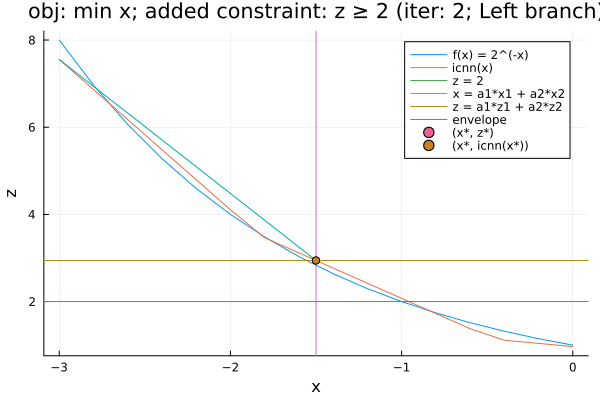

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x; added constraint: z ≥ 2 (itr: 2; Left branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


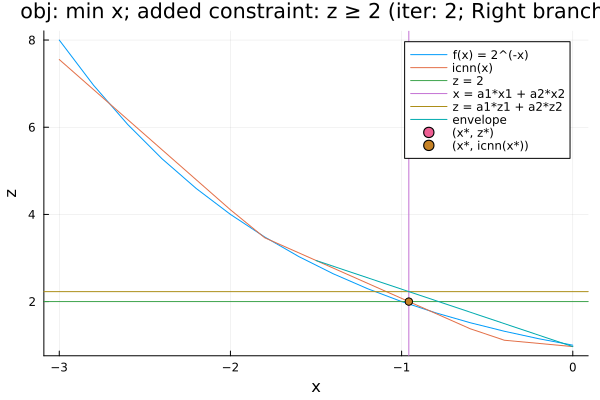

In [ ]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[2]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x; added constraint: z ≥ 2 (itr: 2; Right branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[2]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

In [55]:
# define the new branching sets
extreme_points = [[-1.5, -0.75],[-0.75, 0]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MIN_SENSE, (x,z) -> x)
    # Add the constraint that z >= 2
    @constraint(new_icnn_lp, exm_1, new_icnn_lp[:z] >= 2)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min input_var + output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 1.5 a[1] + 0.75 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -1.5
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 exm_1 : output_var >= 2
 input_var <= -0.75
 constraint_3 : output_var - 2.9427679 a[1] - 1.6384541 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Min input_var + output_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 0.75 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -0.75
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.1206057

┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:263
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\yliuc\.julia\packages\Alpine\2DP5q\src\main_algorithm.jl:569


1-element Vector{Any}:
 (model_index = 1, x_optimal = -0.9578943, z_optimal = 2.0, a_values = [0.2771924, 0.7228076], icnn_z_optimal = 1.9999999)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


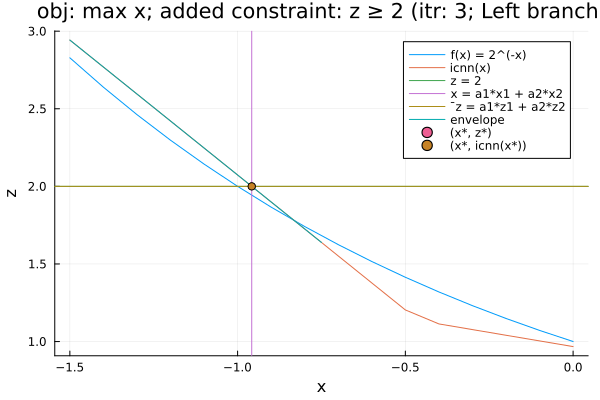

In [65]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -1.5:0.1:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x; added constraint: z ≥ 2 (itr: 3; Left branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

## max x+z

In [97]:
# define the branching sets
extreme_points = [[-3, 0],[0,3]]

2-element Vector{Vector{Int64}}:
 [-3, 0]
 [0, 3]

In [99]:
# if you have multiple extreme points
new_icnn_lp_list_max = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x, z) -> x+z)
    new_icnn_lp_list_max[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list_max, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= 0
 constraint_3 : output_var - 272761.1768557 a[1] - 262054.6374009 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var - 3 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] 

2-element Vector{Any}:
 (model_index = 1, obj_optimal = 5.001841369345123e-9, x_optimal = 0.0, z_optimal = 172892.9980681, a_values = [0.0, 1.0], icnn_z_optimal = 0.9673938)
 (model_index = 2, obj_optimal = 3.0000000249831746, x_optimal = 3.0, z_optimal = 140903.106568, a_values = [0.0, 1.0], icnn_z_optimal = -0.1284143)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

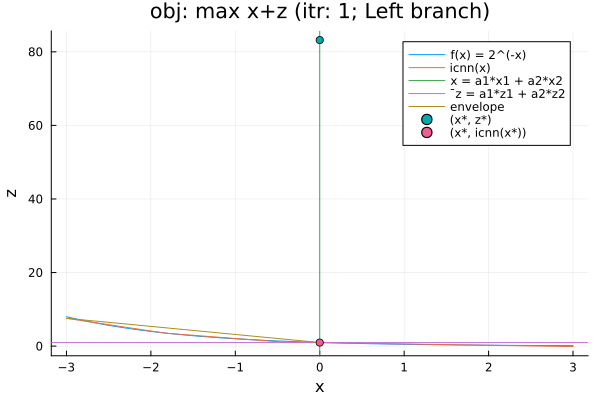

In [90]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x+z (itr: 1; Left branch)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

In [81]:
# define the new branching sets
extreme_points = [[-3, -1.5],[-1.5, 0]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 1.5 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -1.5
 constraint_3 : output_var - 281680.6179087 a[1] - 280833.9456177 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 1.5 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -1.5
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.073

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -1.4999999900208147, x_optimal = -1.5, z_optimal = 117483.5274788, a_values = [0.0, 1.0], icnn_z_optimal = 2.9427679)
 (model_index = 2, obj_optimal = 7.476742115234225e-9, x_optimal = 0.0, z_optimal = 123870.1559439, a_values = [0.0, 1.0], icnn_z_optimal = 0.9673938)

In [82]:
# define the new branching sets
extreme_points = [[-3, -2.25],[-2.25, -1.5]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.25 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.25
 constraint_3 : output_var - 260865.0235232 a[1] - 269938.8519972 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.25 a[1] + 1.5 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.25
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.04866313

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.2499999975018414, x_optimal = -2.25, z_optimal = 176229.3566573, a_values = [0.0, 1.0], icnn_z_optimal = 4.9676687)
 (model_index = 2, obj_optimal = -1.4999999937815442, x_optimal = -1.5, z_optimal = 136859.072293, a_values = [0.0, 1.0], icnn_z_optimal = 2.9427679)

In [83]:
# define the new branching sets
extreme_points = [[-3, -2.625],[-2.625, -2.25]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.625 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.625
 constraint_3 : output_var - 270048.3046408 a[1] - 270250.268063 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.625 a[1] + 2.25 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.625
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.6250000012472636, x_optimal = -2.625, z_optimal = 176339.8903207, a_values = [0.0, 1.0], icnn_z_optimal = 6.260423)
 (model_index = 2, obj_optimal = -2.250000001249897, x_optimal = -2.25, z_optimal = 176243.2494485, a_values = [0.0, 1.0], icnn_z_optimal = 4.9676687)

In [84]:
# define the new branching sets
extreme_points = [[-3, -2.8125],[-2.8125, -2.625]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.8125 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.8125
 constraint_3 : output_var - 266498.8972858 a[1] - 266196.4581253 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.8125 a[1] + 2.625 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.8125
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.8125000031207943, x_optimal = -2.8125, z_optimal = 174611.5649373, a_values = [0.0, 1.0], icnn_z_optimal = 6.9068002)
 (model_index = 2, obj_optimal = -2.625000003122084, x_optimal = -2.625, z_optimal = 180712.5322319, a_values = [0.0, 1.0], icnn_z_optimal = 6.260423)

In [85]:
# define the new branching sets
extreme_points = [[-3, -2.90625],[-2.90625, -2.8125]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.90625 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.90625
 constraint_3 : output_var - 266498.8972858 a[1] - 264098.2299238 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.90625 a[1] + 2.8125 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.90625
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.9062500040583417, x_optimal = -2.90625, z_optimal = 173688.2495941, a_values = [0.0, 1.0], icnn_z_optimal = 7.2299888)
 (model_index = 2, obj_optimal = -2.8125000040586645, x_optimal = -2.8125, z_optimal = 173860.2890809, a_values = [0.0, 1.0], icnn_z_optimal = 6.9068002)

In [86]:
# define the new branching sets
extreme_points = [[-3, -2.953125],[-2.953125, -2.90625]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.953125 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.953125
 constraint_3 : output_var - 266498.8972858 a[1] - 265600.8836958 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.953125 a[1] + 2.90625 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.953125
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] 

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.9531250045228856, x_optimal = -2.953125, z_optimal = 174349.9961655, a_values = [0.0, 0.9999999], icnn_z_optimal = 7.3915831)
 (model_index = 2, obj_optimal = -2.906250004528389, x_optimal = -2.90625, z_optimal = 173679.7013719, a_values = [0.0, 0.9999999], icnn_z_optimal = 7.2299888)

In [100]:
# define the new branching sets
extreme_points = [[-3, -2.9765625],[-2.9765625, -2.953125]]

new_icnn_lp_list = Array{JuMP.Model}(undef, length(extreme_points))

for i in 1:length(extreme_points)
    extreme_points_i = extreme_points[i]
    new_icnn_lp = add_envelope_constraints(filepath, extreme_points_i, MOI.MAX_SENSE, (x,z) -> x+z)
    new_icnn_lp_list[i] = new_icnn_lp
    print(new_icnn_lp)
end

results = optimise_and_print_results(new_icnn_lp_list, icnn_lp)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 3 a[1] + 2.9765625 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -3
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var <= -2.9765625
 constraint_3 : output_var - 266498.8972858 a[1] - 266280.5122676 a[2] <= 0
 a[1] >= 0
 a[2] >= 0

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var
Subject to
 -input_var + _[3] == 0
 output_var - _[6] == 0
 constraint_2 : input_var + 2.9765625 a[1] + 2.953125 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 input_var >= -2.9765625
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 

2-element Vector{Any}:
 (model_index = 1, obj_optimal = -2.976562504767149, x_optimal = -2.9765625, z_optimal = 174648.0571371, a_values = [0.0, 0.9999998], icnn_z_optimal = 7.4723802)
 (model_index = 2, obj_optimal = -2.9531250047637903, x_optimal = -2.953125, z_optimal = 174381.5519775, a_values = [0.0, 0.9999998], icnn_z_optimal = 7.3915831)